In [234]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from sklearn.preprocessing import scale
import pandas as pd
import os
import glob

try:
    os.chdir('piezo_data')
except:
    pass

In [207]:
def notch_filter_60(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 60 Hz filter
    bp_stop = np.array([58.0, 62.0])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)

#     # compute the frequency response
#     w, h = signal.freqz(b, a, int(len(trace)/2.0)
#     f = w*fs/(2.0*np.pi) # convert from rad/sample to Hz
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

# def notch_filter_16k(trace, fs=44100.0):
#     """ digital notch filter to remove one frequency component from the data """
#     # nyquist frequency
#     fny = fs/2.0
    
#     # create the 16100 Hz filter
#     bp_stop = np.array([16050, 16150.0])
#     b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)

# #     # compute the frequency response
# #     w, h = signal.freqz(b, a, int(len(trace)/2.0)
# #     f = w*fs/(2.0*np.pi) # convert from rad/sample to Hz
    
#     # apply filter
#     filtered = signal.filtfilt(b, a, trace)
#     return filtered

def wav_to_df(filename, channel='left'):
    """ return arrays of time and sound amplitude """
    
    sampFreq, snd = wavfile.read(filename)

    # snd = snd / (2.**15) #convert sound array to float pt. values
    
    if channel == 'left':
        channel = 0
    elif channel == 'right':
        channel = 1
    else:
        raise ValueError('Pick a channel!')
    snd = snd[:,channel]
    
    N = len(snd)
    T = np.arange(0,N)/sampFreq
    
    filt = notch_filter_60(snd)
#     filt = notch_filter_16k(filt)
    return pd.DataFrame({'T':T, 'A':snd, 'A_filt':filt})

def get_psd(trace, fs=44100):

    N = len(trace)
    dt = 1/fs # assume everything was taken at 44100 Hz

    yf = fft(trace)
    yf = 2.0/N * np.conjugate(yf) * yf
    xf = np.linspace(0.0, 1.0/(2.0*dt), N/2)
    
    return xf, np.real(yf[:int(N/2)])

def window_fft(trace, width, window='hamming', overlap=0.5):
    """ average fft over windows of length width (in seconds) """
    fs = 44100.0
    pts = int(np.ceil(width*fs))
    step = int(pts*(1-overlap))
    starts = np.arange(0, len(trace)-pts, step)
    if starts[-1]+pts > len(trace)-1:
        starts = starts[:-1]

    if window=='square':
        window = np.ones(pts)
    elif window=='hamming':
        window = np.hamming(pts)
    else:
        raise ValueError('Pick a window!')
    fftall = np.zeros((len(starts),pts/2))
    
    for i,start in enumerate(starts):
        sample = trace[i:i+pts]

        xf, sample_fft = get_psd(sample*window)
        fftall[i,:] = sample_fft*(1.0 / (fs * (window*window).sum()))
    
    return xf, fftall

First thing to look at... 

Plot the FFT of each data set from 20Hz to 20kHz. The lowest frequency I'm really interested in is 30Hz. To resolve that I need a window size of 1/30Hz = 0.033s. That gives me a pretty poor result at 30Hz, so let's go a factor of 10 longer and use 1/3 second windows.

I'm also going to make some digital notch filter to remove the 60Hz component from each sample before averaging them together.

<IPython.core.display.Javascript object>


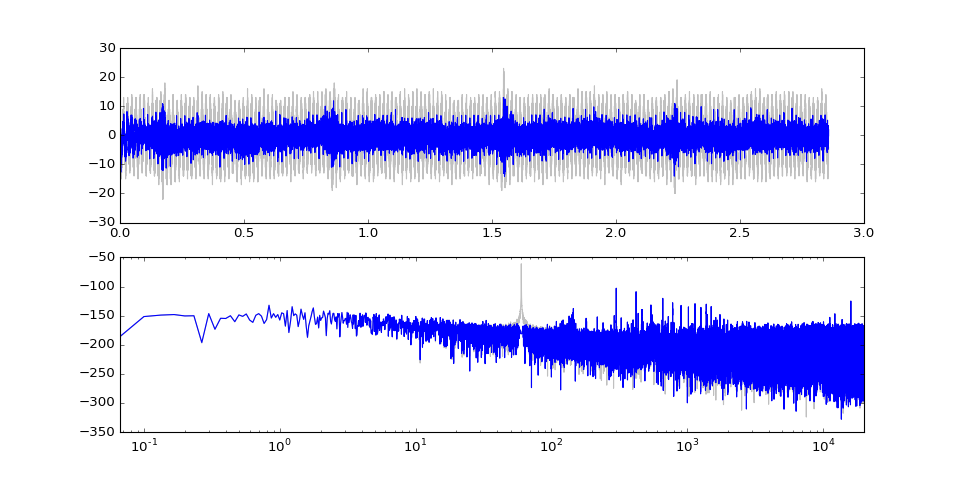

(0.06671790278853601, 20000.0)

In [3]:
# first test out the notch filter

fs = 44100.0 # Hz

# load wave and notch filtered data
df = wav_to_df('cryo4K_pton.wav')

L = int((1/0.7*2)*fs) # lengh of time samples to look at
window = np.ones(len(df/2))

fig, ax = plt.subplots(2,1, figsize = (12,6))
ax[0].plot(df['T'][0:L], df['A'][0:L], color='silver')
ax[0].plot(df['T'][0:L], df['A_filt'][0:L], color='blue')

xf, yf = get_psd(df['A'])
yf *= (1.0 / (fs * (window*window).sum()))
ax[1].plot(xf, 20*np.log10(yf), color='silver')

xf, yff = get_psd(df['A_filt'])
yff *= (1.0 / (fs * (window*window).sum()))
ax[1].plot(xf, 20*np.log10(yff), color='blue')

ax[1].set_xscale('log')
ax[1].set_xlim(2.0/(len(df)/fs), 20e3)

The filter works reasonably well, but it is still not quite removing the entire 60Hz signal. I think it is good enough to continue on.

What I really learned here is that my signal to noise is pretty terrible. The sensor and sound card wiring have a ton of 60Hz pickup. Those headphone wires we used to connect everything are a disaster.

On top of that, there is the problem that I am pretty close to the hardware limits of the sound card. My time trace is very obviously digitized.

At least, with the application of the filter, I recovered the pulse tube sounds in the time trace.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:78: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


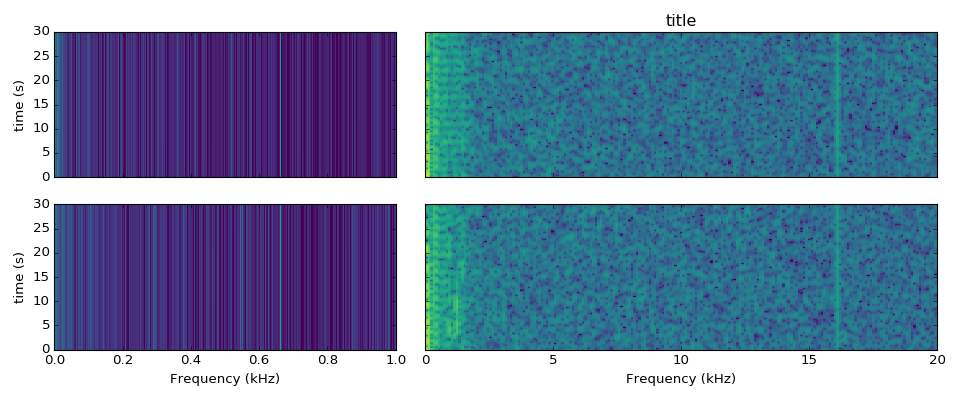

In [92]:
# in these plots I'd like a low frequency and high frequency measurement on the left and right

fs = 44100.0 # Hz
fast_win = 0.01 # seconds
slow_win = 5

# load wave and notch filtered data
df = wav_to_df('cryoMC_pton.wav')
xsf, fftsf = window_fft(df['A_filt'], fast_win)
signal_fast = np.mean(fftsf, axis=0)

xss, fftss = window_fft(df['A_filt'], slow_win)
signal_slow = np.mean(fftss, axis=0)

df = wav_to_df('cryoMC_ptoff.wav')
xbf, fftbf = window_fft(df['A_filt'], fast_win)
back_fast = np.mean(fftbf, axis=0)

xbs, fftbs = window_fft(df['A_filt'], slow_win)
back_slow = np.mean(fftbs, axis=0)

fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1.5])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax3 = plt.subplot(gs[0,1], sharey=ax1)
ax4 = plt.subplot(gs[1,1], sharex=ax3, sharey=ax2)

slow_extent = [xbs[0]/1000,xbs[-1]/1000,0,30]
ax1.imshow(20*np.log10(fftbs), extent = slow_extent, cmap = plt.cm.viridis, vmin=-200, vmax=-50.0, 
             origin='lower', aspect='auto', interpolation='nearest')

ax2.imshow(20*np.log10(fftss), extent = slow_extent, cmap = plt.cm.viridis, vmin=-200, vmax=-50.0, 
             origin='lower', aspect='auto', interpolation='nearest')

fast_extent = [xbf[0]/1000,xbf[-1]/1000,0,30]
ax3.imshow(20*np.log10(fftbf), extent = fast_extent, cmap = plt.cm.viridis, vmin=-200, vmax=-50.0, 
             origin='lower', aspect='auto', interpolation='nearest')

ax4.imshow(20*np.log10(fftsf), extent = fast_extent, cmap = plt.cm.viridis, vmin=-200, vmax=-50.0, 
             origin='lower', aspect='auto', interpolation='nearest')

ax2.set_xlim(0,1)
ax4.set_xlim(0,20)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax2.set_xlabel('Frequency (kHz)')
ax4.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('time (s)')
ax2.set_ylabel('time (s)')
ax3.set_title('title')
gs.tight_layout(fig)

After looking at this for a few minutes, the averaging isn't totally straightforward. For higher frequencies, more averaging helps. The right range seems to be about 0.6s windows. 

For low frequencies, longer windows are needed. To resolve the 140Hz peak above the noise, a window of about 5 seconds works well.

How to look at all this data... 

I definitely want to see these color plots for every data set. And a simple fft would be helpful to highlight the lower frequencies, something like a 1-2s window.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:78: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


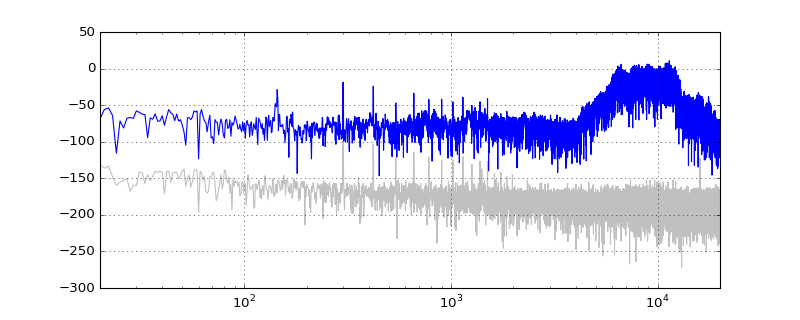

(20, 20000.0)

In [34]:
w = 1 # second
df = wav_to_df('RotValve_ptoff.wav')
xb, ffts = window_fft(df['A_filt'], w)
back_avg = np.mean(ffts, axis=0)

df = wav_to_df('RotValve_pton.wav')
xs, ffts = window_fft(df['A_filt'], w)
signal_avg = np.mean(ffts, axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(xb, 20*np.log10(back_avg), color='silver')
ax.plot(xs, 20*np.log10(signal_avg)+80, color='blue')
ax.grid()
ax.set_xscale('log')
ax.set_xlim(20,20e3)

I really like those two plots. Going to loop through the whole thing and save both of them for each pair of signal/background.

In [99]:
datasets = [('compressor_ptoff.wav', 'compressor_pton.wav'), 
            ('compressorlines_ptoff.wav', 'compressorlines_pton.wav'), 
            ('cryo4K_ptoff.wav', 'cryo4K_pton.wav'), 
            ('cryo50K_ptoff.wav', 'cryo50K_pton.wav'), 
            ('cryoBOB_ptoff.wav', 'cryoBOB_pton.wav'), 
            ('cryoCF_ptoff.wav', 'cryoCF_ptoff_son.wav'),
            ('cryoCF_ptoff.wav', 'cryoCF_pton.wav'),
            ('cryoFrame_high_ptoff.wav', 'cryoFrame_high_pton.wav'), 
            ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_ptoff_son.wav'),
            ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_pton.wav'), 
            ('cryoMC_ptoff.wav', 'cryoMC_pton.wav'), 
            ('cryoPTB_ptoff.wav', 'cryoPTB_pton.wav'), 
            ('cryostill_ptoff.wav', 'cryostill_pton.wav'), 
            ('cryotop_ptoff.wav', 'cryotop_pton.wav'), 
            ('DCrackCA_ptoff.wav', 'DCrackCA_pton.wav'), 
            ('ghc_toff_soff.wav', 'ghc_toff_son.wav'), 
            ('ghc_toff_soff.wav', 'ghc_ton_son.wav'),
            ('ghc_toff_soff.wav', 'ghc_ton_son_pton.wav'),
            ('isoplate_ptoff.wav', 'isoplate_pton.wav'), 
            ('RotValve_ptoff.wav', 'RotValve_pton.wav')]

onoff = ['PT', 
         'PT', 
         'PT', 
         'PT', 
         'PT', 
         'Scroll', 
         'PT', 
         'PT', 
         'Scroll', 
         'PT', 
         'PT', 
         'PT', 
         'PT', 
         'PT',
         'PT',
         'Scroll',
         'Turbo+Scroll',
         'Turbo+Scroll+PT',
         'PT', 
         'PT',]

locations = ['Compressor', 
             'Compressor Lines', 
             '4K plate', 
             '50K plate', 
             'Breakout Box', 
             'Cold Finger', 
             'Cold Finger', 
             'Frame (High)', 
             'Frame (Low)', 
             'Frame (Low)', 
             'Mixing Chamber', 
             'Pulse Tube Balast', 
             'Still', 
             '300K Plate', 
             'DC Rack (Current Amp)', 
             'Gas Handling Cabinet', 
             'Gas Handling Cabinet', 
             'Gas Handling Cabinet', 
             'Isolation Plate', 
             'Rotary Valve']

for i, names in enumerate(datasets):
    print(i, names, locations[i], onoff[i])

0 ('compressor_ptoff.wav', 'compressor_pton.wav') Compressor PT
1 ('compressorlines_ptoff.wav', 'compressorlines_pton.wav') Compressor Lines PT
2 ('cryo4K_ptoff.wav', 'cryo4K_pton.wav') 4K plate PT
3 ('cryo50K_ptoff.wav', 'cryo50K_pton.wav') 50K plate PT
4 ('cryoBOB_ptoff.wav', 'cryoBOB_pton.wav') Breakout Box PT
5 ('cryoCF_ptoff.wav', 'cryoCF_ptoff_son.wav') Cold Finger Scroll
6 ('cryoCF_ptoff.wav', 'cryoCF_pton.wav') Cold Finger PT
7 ('cryoFrame_high_ptoff.wav', 'cryoFrame_high_pton.wav') Frame (High) PT
8 ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_ptoff_son.wav') Frame (Low) Scroll
9 ('cryoFrame_low_ptoff.wav', 'cryoFrame_low_pton.wav') Frame (Low) PT
10 ('cryoMC_ptoff.wav', 'cryoMC_pton.wav') Mixing Chamber PT
11 ('cryoPTB_ptoff.wav', 'cryoPTB_pton.wav') Pulse Tube Balast PT
12 ('cryostill_ptoff.wav', 'cryostill_pton.wav') Still PT
13 ('cryotop_ptoff.wav', 'cryotop_pton.wav') 300K Plate PT
14 ('DCrackCA_ptoff.wav', 'DCrackCA_pton.wav') DC Rack (Current Amp) PT
15 ('ghc_toff_soff.wa

In [116]:
# plot all FFTs averaged over 1 second windows

w = 1 # second

for i, names in enumerate(datasets):
    df = wav_to_df(names[0])
    xb, ffts = window_fft(df['A_filt'], w)
    back_avg = np.mean(ffts, axis=0)

    df = wav_to_df(names[1])
    xs, ffts = window_fft(df['A_filt'], w)
    signal_avg = np.mean(ffts, axis=0)

    fig, ax = plt.subplots(1,1, figsize=(7,3))
    ax.plot(xb, 20*np.log10(back_avg), color='silver')
    ax.plot(xs, 20*np.log10(signal_avg)+80, color='blue')
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlim(20,20e3)
    title = '({0:d}) {1} -- {2} ON/OFF'.format(i, locations[i], onoff[i])
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('arb / Hz')
    output = 'plots/'+'{0}_{1}_single_fft'.format(locations[i].replace(' ', '_'), onoff[i])
    fig.tight_layout()
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:78: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [128]:
# plot FFTs as a function of time with fast and slow windows
# in these plots I'd like a low frequency and high frequency measurement on the left and right

fs = 44100.0 # Hz
fast_win = 0.01 # seconds
slow_win = 5
colormap = plt.cm.Reds

for i, names in enumerate(datasets):
    # load wave and notch filtered data
    df = wav_to_df(names[1])
    xsf, fftsf = window_fft(df['A_filt'], fast_win)
    signal_fast = np.mean(fftsf, axis=0)

    xss, fftss = window_fft(df['A_filt'], slow_win)
    signal_slow = np.mean(fftss, axis=0)

    df = wav_to_df(names[0])
    xbf, fftbf = window_fft(df['A_filt'], fast_win)
    back_fast = np.mean(fftbf, axis=0)

    xbs, fftbs = window_fft(df['A_filt'], slow_win)
    back_slow = np.mean(fftbs, axis=0)

    fig = plt.figure(figsize=(8,4))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1.5])
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1,0], sharex=ax1)
    ax3 = plt.subplot(gs[0,1], sharey=ax1)
    ax4 = plt.subplot(gs[1,1], sharex=ax3, sharey=ax2)

    slow_extent = [xbs[0]/1000,xbs[-1]/1000,0,30]
    ax1.imshow(20*np.log10(fftbs), extent = slow_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax2.imshow(20*np.log10(fftss), extent = slow_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    fast_extent = [xbf[0]/1000,xbf[-1]/1000,0,30]
    ax3.imshow(20*np.log10(fftbf), extent = fast_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax4.imshow(20*np.log10(fftsf), extent = fast_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax2.set_xlim(0,1)
    ax4.set_xlim(0,20)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    ax2.set_xlabel('Frequency (kHz)')
    ax4.set_xlabel('Frequency (kHz)')
    ax1.set_ylabel('time (s)')
    ax2.set_ylabel('time (s)')
    title = '({0:d}) {1} -- {2} ON/OFF'.format(i, locations[i], onoff[i])
    ax3.set_title(title)
    output = 'plots/'+'{0}_{1}_time_fft'.format(locations[i].replace(' ', '_'), onoff[i])
    gs.tight_layout(fig)
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:78: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [236]:
fs = 44100.0 # Hz
fast_win = 0.01 # seconds

for i in range(len(datasets)):
    
    # load wave and notch filtered data
    df = wav_to_df(datasets[i][1])
    xhamm, fft_hamm = window_fft(df['A_filt'], fast_win, window='hamming', overlap = 0.5)
    
    # look only at audible frequencies
    j = np.abs(xsq-200).argmin()
    k = np.abs(xsq-5e3).argmin()
    fft_hamm = fft_hamm[:,j:k]
    
    fig, ax = plt.subplots(1,1, figsize = (7,3))
    
    out_hamm = np.zeros(len(fft_hamm)/2)
    for n in range(fft_hamm.shape[1]):
        xf, yf = get_psd(fft_hamm[:,n], fs=1/fast_win)
        out_hamm+=yf

    ax.loglog(xf,out_hamm/len(fft_hamm), 'r')
    ax.grid()
    title = '({0:d}) {1} -- {2} ON/OFF'.format(i, locations[i], onoff[i])
    ax.set_title(title)
    output = 'plots/'+'{0}_{1}_low_freq_correlations'.format(locations[i].replace(' ', '_'), onoff[i])
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:83: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


This about does it for this analysis. I need some better hardware.

First thing to look at, the amplifier response...

(0.1, 1000)

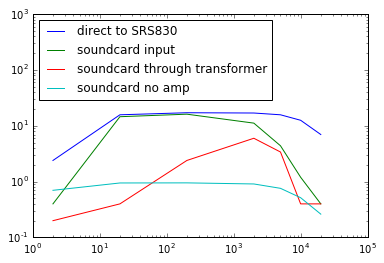

In [237]:
# checking amplifier response

f = np.array([2.0, 20.0, 200.0, 2000.0, 5000.0, 10000.0, 20000.0])
A0 = np.array([0.12, 0.79, 0.86, 0.85, 0.79, 0.63, 0.35])/0.05
A1 = np.array([0.02, 0.73, 0.81, 0.56, 0.22, 0.06, 0.02])/0.05
A2 = np.array([0.01, 0.02, 0.12, 0.30, 0.17, 0.02, 0.02])/0.05
A3 = np.array([0.35, 0.474, 0.476, 0.455, 0.38, 0.258, 0.131])/0.5

fig, ax = plt.subplots(1,1)
ax.loglog(f, A0, label='direct to SRS830')
ax.loglog(f, A1, label='soundcard input')
ax.loglog(f, A2, label='soundcard through transformer')
ax.loglog(f, A3, label='soundcard no amp')
ax.legend(loc='upper left')
ax.set_ylim(0.1, 1000)

That is terrible. I need new hardware here. 

1. Build new amplifier. 10-100 gain. High input impedance. Can drive small load. Runs on single 9V battery. AC coupled.